# Analysis of the Online retail dataset

In [1]:
# initializing the Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 

In [2]:
# loading the retail dataset and saving it in the varible df
df = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("online-retail-dataset.csv")

In [3]:
# checking the columns and the data types 
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



### 1. What is the total number of records in the online-retail-dataset?

In [4]:
# using the count function to count the number of records and store them in the 'total_records' variable
total_records = df.count()

print(f"Total number of record: {total_records}")

Total number of record: 541909


### 2. Most of the customers belong to which country?

In [5]:
from pyspark.sql.functions import countDistinct, col

# group the data by country and count the distinct customer IDs for each country
max_country = df.select("Country", "CustomerID") \
    .groupBy("Country") \
    .agg(countDistinct("CustomerID").alias("distinct_customers")) \
    .orderBy("distinct_customers", ascending=False) \
    .select("Country") \
    .first()[0]

# agg function counts the distinct customer IDs for each country group and aliases the result as "distinct_customers"
# order by distinct_customers in descending order so that it is then easier to select the first country
# take the first row and select the first value which is the country name with the max distinct customers

print(f"Most customers belong to: {max_country}")

Most customers belong to: United Kingdom


### 3. In description of how many items, color 'blue' is used?

In [6]:
from pyspark.sql.functions import lower

# filter the dataframe to include only the rows where the 'Description' column contians the substring 'blue'
# convert both 'Description' column and search string to lowercase for case-insensitive search
blue_count = df.filter(lower(col("Description")).like("%blue%")).count()

print(f"Number of items with 'blue' in the description: {blue_count}")

Number of items with 'blue' in the description: 20154


### 4. Identify the customer ID, which placed most orders.

In [7]:
# filter out null values from the 'CustomerID' column because otherwise the output will be none
df_filtered = df.filter(col("CustomerID").isNotNull())

# Group the sum of distinct invoice numbers by customer ID and order them in descending order
max_orders_customer = df_filtered.select("CustomerID", "InvoiceNo") \
    .groupBy("CustomerID") \
    .agg(countDistinct("InvoiceNo").alias("order_count")) \
    .orderBy("order_count", ascending=False) \
    .first()[0]

print(f"Customer ID with most orders: {max_orders_customer}")

Customer ID with most orders: 14911


### 5. Identify the customer ID, which bought the least number of products.

In [8]:
from pyspark.sql.functions import coalesce, sum, lit

# group the quantity of products by customer ID and order the data by the sum of quantity in descending order
# coalesce function replaces any null values in the 'Quantity' column with 0

min_products_customer = df.select("CustomerID", coalesce("Quantity", lit(0)).alias("Quantity")) \
    .groupBy("CustomerID") \
    .agg(sum("Quantity").alias("total_products")) \
    .orderBy("total_products") \
    .select("CustomerID") \
    .first()[0]

print(f"Customer ID with least number of products: {min_products_customer}")

Customer ID with least number of products: 16546


### 6. What is the range of dates in which this dataset was collected?

In [10]:
from pyspark.sql.functions import min, max, to_timestamp

# make sure the InvoiceDate column has the dates in the proper format with the to_timestamp function and specify the desired format, this will be useful in furthe analysis
df = df.withColumn("InvoiceDate", to_timestamp("InvoiceDate", "M/d/yyyy H:m"))

min_date = df.select(min("InvoiceDate")).first()[0]
max_date = df.select(max("InvoiceDate")).first()[0]

print(f"Range of dates: {min_date} - {max_date}")

Range of dates: 2010-12-01 08:26:00 - 2011-12-09 12:50:00


### 7. Plot the number of orders against the hour of the day to demonstrate when most of the sales take place?

In [17]:
from pyspark.sql.functions import hour
import pandas as pd
import matplotlib.pyplot as plt

# group the orders by hour and save it in the 'orders_by_hour' variable
# use the hour function to extract the hour from the 'InvoiceDate' column
orders_by_hour = df.select("InvoiceNo", hour("InvoiceDate").alias("hour")) \
    .groupBy("hour") \
    .agg(countDistinct("InvoiceNo").alias("order_count")) \
    .orderBy("Hour")

# transform the 'orders_by_hour' dataframe into a pandas dataframe for visualization
orders_by_hour_pddf = orders_by_hour.toPandas()

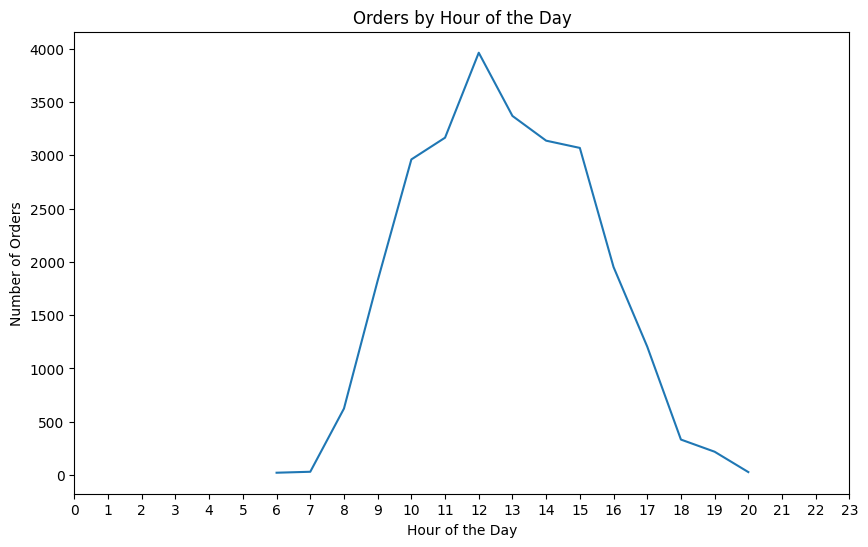

In [18]:
# create a line plot
plt.figure(figsize=(10, 6))
plt.plot(orders_by_hour_pddf['hour'], orders_by_hour_pddf['order_count']) # set the x and the y axis columns
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.title('Orders by Hour of the Day')
plt.xticks(range(0, 24))  # set x-axis ticks from 0 to 23
plt.show()

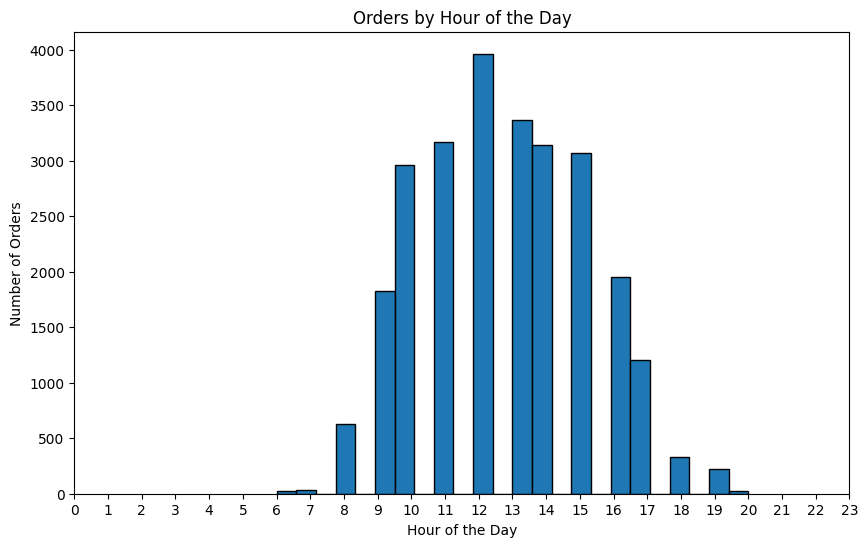

In [19]:
# create a histogram 
plt.figure(figsize=(10, 6))
plt.hist(orders_by_hour_pddf['hour'], bins=24, edgecolor='black', weights=orders_by_hour_pddf['order_count'])
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.title('Orders by Hour of the Day')
plt.xticks(range(24)) # set x-axis ticks from 0 to 23
plt.show()

From the line plot and the histogram above we can see that the highest frequency or number of orders is midday, around 12pm and the lowest frequency is during the night (from 8pm till 6am there is no orders according to this data). These results are expected, since it is highly unlikely for consumers to place orders during the night. Of course, this depends on whether the company operates localy (only in one time zone) or internationally, becuase then there could be peaks during the "night' because it would be daytime in another time zone. Overall, most orders are placed around midday which can be useful information for the company for example, when to send advertisements or promotional emails to customers to encourage them to buy a product. 

### 8. How many unique stocks are on offer in the online retail store?

In [20]:
# select distinct values in the 'StockCode' column and count them
unique_stock = df.select("StockCode").distinct().count()

print(f"Number of unique stocks: {unique_stock}")

Number of unique stocks: 4070


### 9. What is the total number of invoices given in the dataset?

In [21]:
# select distinct values in the 'InvoiceNo' column and count them
total_invoices = df.select("InvoiceNo").distinct().count()

print(f"Total number of invoices: {total_invoices}")

Total number of invoices: 25900
